# # HW4 - A Guided Homework on Proxies for Estimating Ranking of Vision Transformer Architectures
 
**Requirements:**
- Python 3 (tested on v3.7.16)
- numpy==1.21.5
- torch==1.13.1
- torchvision==0.14.1
- timm==0.4.12
- opencv-python==4.9.0.80
- scipy==1.7.3
- scikit-image==0.19.2
- pyyaml==5.4.1
- easydict==1.13
- matplotlib
- ipykernel

### 0. Prelim: Import packages

In [4]:
import random
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
from timm.utils.model import unwrap_model
from lib.datasets import build_dataset
from lib import utils
import json
from scipy import stats
import json
from torch import nn
import matplotlib.pyplot as plt

### 1. Prelim: Hyperparameters and configuration

In [5]:
batch_size=8
api_Auto_FM_Benchmark='./AutoFM_CVPR2022_API_5_7M.json'
input_size=224
data_path='./dataset/imagenet'              
seed=0
num_workers=0

In [6]:
# The code is cpu-friendly, but running the notebook with GPU(s) will drastically speed up the computation.

# Define device for torch
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available: False


### 2. Prelim: Dataset and Dataloader

This section loads data into PyTorch Dataloaders.

In [7]:
# Fixed the seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Enables automatic selection of the most efficient algorithms for deep learning operations
cudnn.benchmark = True

### Build the dataloader ###
dataset_val, nb_classes = build_dataset(True, data_path, input_size, "train")  # load data of one batch
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=batch_size,
    sampler=sampler_val, num_workers=num_workers,
    pin_memory=True, drop_last=False
)

### 3. Load Vision Transformer architectures
In this homework, you will write proxies to predict the ranking of Vision Transformer architectures. In particular, you will compute the proxy scores based on the initialized weights, using one forward and backward pass of one minibatch of samples. No training is performed on the Vision Transformers to predict the ranking. 

We have already prepared 50 Vision Transformer architectures for this homework. For evaluation of the performance of the proxies in ranking, we also provide test accuracy for these architectures. Note that the test accuracy is not used in the proxies. The test accuracy is used only to evaluate the effectiveness of the proxy scores for ranking. 

First, we load 50 architectures into arch_candidate_set. For each architecture, following information is included:

1) the architectural configuration;

2) the test accuracy (for image classification) on ImageNet-1k validation set. This information is not used in the proxies. This test accuracy is for evaluating the proxies in architecture ranking.

In [8]:
# Load candidate architectures
from model.get_Vision_Transformer_Arch import model_VIT
file_api = open(api_Auto_FM_Benchmark)
arch_candidate_set =json.load(file_api)

CUDA is available: False


### 4. Develop functions to compute Proxies for Ranking Vision Transformer Architectures

This section studies some proxies that estimate the ranking of Vision Transformer architectures, based on only the initialized weights and the associated gradients in one forward and backward pass.

**Learnable parameters**: For Vision Transformers [1], the learnable parameters are mainly from linear layers (denoted by 'nn.linear' in PyTorch) of different components (self-attention, multilayer perceptron, etc). Particularly, in this exercise, the patch embeddings in the Vision Transformers are obtained via 2-D convolutions instead of linear projection of flattened patches (details omitted). 

In summary, the learnable parameters can be found in 'nn.Linear' and 'nn.Conv2d' modules.

In [9]:
def combine_net_proxy(net, metric):
    metric_array = []

    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            metric_array.append(metric(layer))
    
    return sum(metric_array).item()

**Question 1**: Write your proxies: grad_norm and SNIP

The goal is to design a proxy (function) that can predict the ranking Vision Transformer architectures, without training the networks [3]. We will consider some simple proxies:

**Gradient Norm (grad_norm)**: This proxy computes the Euclidean norm of the gradients by layer [3] at network initialization. A large grad_norm could indicate more significant coefficients in the network, suggesting a better network architecture. 

In [24]:
def get_grad_norm_scores(net, inputs, targets, loss_fn):
  grad_norm_arr = 0

  outputs = net(inputs)
  loss = loss_fn(outputs, targets)

  net.zero_grad()

  loss.backward()

  for layer in net.modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
      if layer.weight.grad is not None:
        grad = layer.weight.grad
        grad_norm = grad.norm(2).item()
        grad_norm_arr += grad_norm

  return grad_norm_arr


**SNIP**: This proxy sums up the absolute values of all the weights multiplied by their gradients [3,4] at initialization. A large SNIP could indicate a better network architecture.

In [25]:
def get_SNIP_scores(net, inputs, targets, loss_fn):
  
  SNIP_arr = 0

  outputs = net(inputs)
  loss = loss_fn(outputs, targets)

  net.zero_grad()

  loss.backward()

  for layer in net.modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
      weight = layer.weight
      grad = weight.grad
      
      wgp = weight * grad
      SNIP_arr += torch.sum(torch.abs(wgp)).item()

  return SNIP_arr



### 5. Using the Proxies to estimate the ranking of Vision Transformer Architectures
This section computes the proxy scores for the Vision Transformer architectures in arch_candidate_set, which were loaded in step 3.

**Leveraging Vision Transformer architectures' information**: We will utilize the information for each architecture in arch_candidate_set: 

- **Architecture configuration**: This allows us to create the corresponding PyTorch model representing the specific Vision Transformer architecture. Then, we apply our proxies on the model.
- **Test accuracy**: The provided test accuracy will be used to evalute the ranking obtained by our proxy scores. 

**Proxy Computation**: We will employ the proxies: **grad_norm**, **SNIP** (defined earlier) to compute proxy scores for each Vision Transformer architecture in arch_candidate_set. The proxy scores predict the ranking of the Vision Transformer architectures without actually training them.

In [26]:
### get data sample for proxy computation ###
x, y = next(iter(data_loader_val))
x = x.to(device)
y = y.to(device)

# specify the loss function for proxy computation
lossfunc = nn.CrossEntropyLoss().cuda()

# specify the proxy
proxy = 'grad_norm' 

# get 50 architectures and compute the proxy scores
proxy_scores = []
accs = []
st_time = time.time()

for arch_idx, arch_info in arch_candidate_set.items():
    if int(arch_idx) == 50:
        break
    e_time = time.time()
    
    # get network information (configuration, test accuracy) from API
    net_setting = arch_info['net_setting']
    net_arch = unwrap_model(model_VIT)
    net_arch.set_sample_config(config=net_setting)
    net_arch.to(device)

    # compute for the proxy
    if proxy == 'grad_norm':
        res = get_grad_norm_scores(net_arch, x, y,lossfunc)
    elif proxy =='snip':
        res = get_SNIP_scores(net_arch,x, y, lossfunc)

    # Store the results for computing the correlation between the proxy and test accuracy
    del net_arch
    print('Architectures: ',arch_idx)
    print('Test-Accuracy: ', arch_info['test-accuracy'])
    proxy_scores.append(res)
    accs.append(arch_info['test-accuracy'])
    print('Proxy score: ',res)
    edl_time = time.time()
    print('Computation Time: ',edl_time-e_time)   
    print('---------------------------------------------')
end_time = time.time()
print('total time: ',end_time-st_time)

Architectures:  0
Test-Accuracy:  75.33999999755859
Proxy score:  36.4464830160141
Computation Time:  1.0806670188903809
---------------------------------------------
Architectures:  1
Test-Accuracy:  75.21799999877929
Proxy score:  34.277665585279465
Computation Time:  0.7967450618743896
---------------------------------------------
Architectures:  2
Test-Accuracy:  75.29799999755859
Proxy score:  34.792975068092346
Computation Time:  0.7833027839660645
---------------------------------------------
Architectures:  3
Test-Accuracy:  75.3259999987793
Proxy score:  34.848502695560455
Computation Time:  0.7646279335021973
---------------------------------------------
Architectures:  4
Test-Accuracy:  75.28799999633789
Proxy score:  34.39896446466446
Computation Time:  0.7137081623077393
---------------------------------------------
Architectures:  5
Test-Accuracy:  75.2159999975586
Proxy score:  34.35873652994633
Computation Time:  0.771946907043457
---------------------------------------

### 6. Evaluating Proxy Effectiveness
This section focuses on evaluating the effectiveness of the proxy in predicting the ranking of architectures.

**Correlation Analysis**: We will calculate Kendall correlation between the ranking based on the proxy scores and the ranking based on the provided test accuracies.

In [27]:
# Compute correlation with accuracy
kendalltau = stats.kendalltau(proxy_scores, accs)
print('*'*50)
print('Kendalltau:', kendalltau)

**************************************************
Kendalltau: SignificanceResult(statistic=0.34463049014351776, pvalue=0.0004154128599072558)


### 7. Visualizing the Correlation Distribution
This section visualizes the correlation between the proxy scores and the test accuracies.

Text(0.5, 0, 'Proxy Scores')

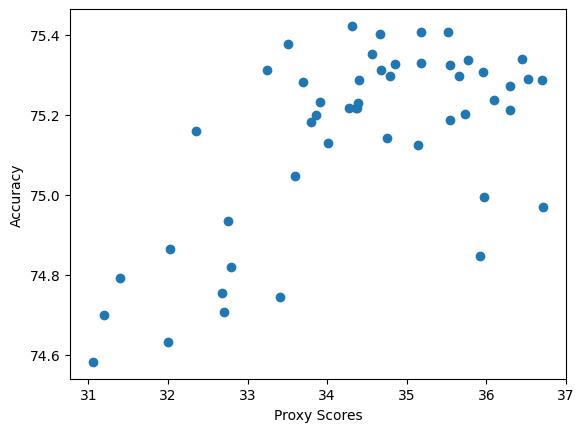

In [28]:
plt.scatter(x=proxy_scores, y=accs)
plt.ylabel("Accuracy")
plt.xlabel("Proxy Scores")

### 8. Identifying Top Architectures based on Proxies
This section focuses on identifying the top-performing architectures based on the computed proxy scores.

**Ranking by Proxy Scores*: We will sort the architectures in descending order based on their proxy scores. This ranking prioritizes architectures with higher predicted performance.

**Top Architectures**: We can then identify the top-ranked architectures (e.g., top 1 or top 5) as potential candidates for further exploration.

In [29]:
from model.get_subnet_Vision_Transformer_Arch import get_subnet_arch

# Get the index of top-1 architecture based on the proxy scores
best_index_architectures = np.argmax(proxy_scores)

# Load the top-1 architecture and check the layer-wise details
net_arch = arch_candidate_set[str(best_index_architectures)]['net_setting']
model_best_by_proxys = get_subnet_arch(net_arch)


print(model_best_by_proxys)

Vision_TransformerSubnet(
  (patch_embed_super): PatchembedSuper(
    (proj): Conv2d(3, 216, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): TransformerEncoderLayer(
      (drop_path): Identity()
      (attn): AttentionSuper(
        (qkv): qkv_super(in_features=216, out_features=648, bias=True)
        (rel_pos_embed_k): RelativePosition2D_super()
        (rel_pos_embed_v): RelativePosition2D_super()
        (proj): LinearSuper(in_features=216, out_features=216, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (attn_layer_norm): LayerNormSuper((216,), eps=1e-05, elementwise_affine=True)
      (ffn_layer_norm): LayerNormSuper((216,), eps=1e-05, elementwise_affine=True)
      (fc1): LinearSuper(in_features=216, out_features=756, bias=True)
      (fc2): LinearSuper(in_features=756, out_features=216, bias=True)
    )
    (1-2): 2 x TransformerEncoderLayer(
      (drop_path): DropPath(

### Reference

[1] Dosovitskiy, Alexey, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani et al. "An image is worth 16x16 words: Transformers for image recognition at scale." arXiv preprint arXiv:2010.11929 (2020).

[2] Chen, Minghao, Houwen Peng, Jianlong Fu, and Haibin Ling. "Autoformer: Searching transformers for visual recognition." In Proceedings of the IEEE/CVF international conference on computer vision, pp. 12270-12280. 2021.

[3] Li, Guihong, Duc Hoang, Kartikeya Bhardwaj, Ming Lin, Zhangyang Wang, and Radu Marculescu. "Zero-Shot Neural Architecture Search: Challenges, Solutions, and Opportunities." arXiv preprint arXiv:2307.01998 (2023).

[4] Lee, Namhoon, Thalaiyasingam Ajanthan, and Philip HS Torr. "Snip: Single-shot network pruning based on connection sensitivity." arXiv preprint arXiv:1810.02340 (2018).